In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit
import matplotlib.pyplot as plt

In [2]:
# x_train = pd.read_csv('Xtrain.csv').drop(columns=['Unnamed: 0']).to_numpy()
# columns_except_evi = np.arange(x_train.shape[1]) != 4
# x_train_wo_evi = x_train[:, columns_except_evi]
# y_train = pd.read_csv('ytrain.csv').drop(columns=['Unnamed: 0']).to_numpy().ravel()

# x_val = pd.read_csv('Xval.csv').drop(columns=['Unnamed: 0']).to_numpy()
# x_val_wo_evi = x_val[:, columns_except_evi]
# y_val = pd.read_csv('yval.csv').drop(columns=['Unnamed: 0']).to_numpy().ravel()

# # For RandomSeachCV, we will need to combine training and validation 
# # sets then specify which portion is training and which is validation
# # Also, for the final performance evaluation, train on all of 
# # the training AND validation data
# X_train_plus_val = np.concatenate((x_train, x_val), axis=0)
# x_train_plus_val_wo_evi = X_train_plus_val[:, columns_except_evi]
# y_train_plus_val = np.concatenate((y_train, y_val), axis=0)

# # Create a predefined train/test split for RandomSearchCV (to be used later)
# validation_fold = np.concatenate((-1 * np.ones(len(y_train)), np.zeros(len(y_val))))
# train_val_split = PredefinedSplit(validation_fold)

# x_test = pd.read_csv('XTopTestTrain.csv').drop(columns=['Unnamed: 0']).to_numpy()
# x_test_wo_evi = x_test[:, columns_except_evi]
# y_test = pd.read_csv('yTopTestTrain.csv').drop(columns=['Unnamed: 0']).to_numpy().ravel()

In [2]:
X_train = np.loadtxt("X_train.txt")
x_train_wo_evi = X_train[:, :48]
y_train = np.loadtxt('y_train.txt')

X_val = np.loadtxt("X_val.txt")
x_val_wo_evi = X_val[:, :48]
y_val = np.loadtxt('y_val.txt')

X_test = np.loadtxt("X_test.txt")
x_test_wo_evi = X_test[:, :48]
y_test = np.loadtxt('y_test.txt')


# For RandomSeachCV, we will need to combine training and validation 
# sets then specify which portion is training and which is validation
# Also, for the final performance evaluation, train on all of 
# the training AND validation data
X_train_plus_val = np.concatenate((X_train, X_val), axis=0)
x_train_plus_val_wo_evi = X_train_plus_val[:, :48]
y_train_plus_val = np.concatenate((y_train, y_val), axis=0)
# Create a predefined train/test split for RandomSearchCV
validation_fold = np.concatenate((-1 * np.ones(len(y_train)), np.zeros(len(y_val))))
train_val_split = PredefinedSplit(validation_fold)

In [20]:
X_train[0].reshape(17,-1)

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.],
       [  1.,  18., 206.]])

In [21]:
x_train_wo_evi[0].reshape(16,-1)

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.]])

### I. Linear Regression Baseline

### II. BASIC RANDOM FOREST WITH ALL BANDS (TABLE 1)

In [3]:
# # DEFAULT RANDOM FOREST WITH ALL BANDS except EVI
# rf_model_base = RandomForestRegressor(random_state=1)

# rf_model_base.fit(x_train_wo_evi, y_train)

# print(f"""
# Training MSE: {mse(y_train, rf_model_base.predict(x_train_wo_evi))}
# Training RMSE: {np.sqrt(mse(y_train, rf_model_base.predict(x_train_wo_evi)))}
# Validation MSE: {mse(y_val, rf_model_base.predict(x_val_wo_evi))}
# Validation RMSE: {np.sqrt(mse(y_val, rf_model_base.predict(x_val_wo_evi)))}
# Test MSE: {mse(y_test, rf_model_base.predict(x_test_wo_evi))}
# Test RMSE: {np.sqrt(mse(y_test, rf_model_base.predict(x_test_wo_evi)))}
# """)


Training MSE: 450.30000751619644
Training RMSE: 21.220273502389087
Validation MSE: 4196.1280321969325
Validation RMSE: 64.77752721582488
Test MSE: 4182.331303932593
Test RMSE: 64.67094636645264



In [22]:
# Run DEFAULT RANDOM FOREST WITH ALL BANDS except EVI three times 
# to get the average test RMSE and standard deviation of the RMSE for the default random forest model
rmse_lst_1 = []
r_2_lst_1 = []

for i in range(3):
    rf_model_base = RandomForestRegressor().fit(x_train_wo_evi, y_train)
    print(f"""
Training MSE: {mse(y_train, rf_model_base.predict(x_train_wo_evi))}
Training RMSE: {np.sqrt(mse(y_train, rf_model_base.predict(x_train_wo_evi)))}
Validation MSE: {mse(y_val, rf_model_base.predict(x_val_wo_evi))}
Validation RMSE: {np.sqrt(mse(y_val, rf_model_base.predict(x_val_wo_evi)))}
Test MSE: {mse(y_test, rf_model_base.predict(x_test_wo_evi))}
Test RMSE: {np.sqrt(mse(y_test, rf_model_base.predict(x_test_wo_evi)))}
""")
    rmse_lst_1.append(np.sqrt(mse(y_test, rf_model_base.predict(x_test_wo_evi))))
    r_2_lst_1.append(rf_model_base.score(x_test_wo_evi, y_test))

#calculate standard deviation of RMSE
std_1 = np.std(rmse_lst_1)
print(f"""
Test RMSEs: {rmse_lst_1}
Average Test RMSE: {np.mean(rmse_lst_1):.2f}
Standard Deviation of Test RMSE: {std_1:.2f}
Test R^2: {r_2_lst_1}
average R^2: {np.mean(r_2_lst_1):.2f}
""")


Training MSE: 447.747314508847
Training RMSE: 21.16004051293019
Validation MSE: 4182.310727089386
Validation RMSE: 64.67078727748245
Test MSE: 4167.40548080033
Test RMSE: 64.55544501279756


Training MSE: 445.03886095430136
Training RMSE: 21.09594418257456
Validation MSE: 4192.813221572383
Validation RMSE: 64.75193604497385
Test MSE: 4175.418894575483
Test RMSE: 64.61748133884115


Training MSE: 449.1695002945493
Training RMSE: 21.193619329754636
Validation MSE: 4184.913758604393
Validation RMSE: 64.69090939694999
Test MSE: 4187.754627507485
Test RMSE: 64.71286292158217


Test RMSEs: [64.55544501279756, 64.61748133884115, 64.71286292158217]
Average Test RMSE: 64.63
Standard Deviation of Test RMSE: 0.06
Test R^2: [0.019012085093448094, 0.017125764670156585, 0.01422199037136096]
average R^2: 0.02



In [23]:
# xgboost WITH ALL BANDS except EVI
import xgboost as xgb
# XGBoost with all bands
xgb_default = xgb.XGBRegressor() #tuning learning rate did not help?

xgb_default.fit(x_train_wo_evi, y_train)

print(f"""
Training MSE: {mse(y_train, xgb_default.predict(x_train_wo_evi))}
Training RMSE: {np.sqrt(mse(y_train, xgb_default.predict(x_train_wo_evi)))}
Validation MSE: {mse(y_val, xgb_default.predict(x_val_wo_evi))}
Validation RMSE: {np.sqrt(mse(y_val, xgb_default.predict(x_val_wo_evi)))}
Test MSE: {mse(y_test, xgb_default.predict(x_test_wo_evi))}
Test RMSE: {np.sqrt(mse(y_test, xgb_default.predict(x_test_wo_evi)))}
""")


Training MSE: 1455.4607637548763
Training RMSE: 38.15050148759353
Validation MSE: 4238.5450994967105
Validation RMSE: 65.10410969744315
Test MSE: 4340.534633390086
Test RMSE: 65.88273395503624



In [6]:
# # DEFAULT RANDOM FOREST WITH ALL BANDS with EVI
# rf_model_base = RandomForestRegressor()

# rf_model_base.fit(X_train, y_train)

# print(f"""
# Training MSE: {mse(y_train, rf_model_base.predict(X_train))}
# Training RMSE: {np.sqrt(mse(y_train, rf_model_base.predict(X_train)))}
# Validation MSE: {mse(y_val, rf_model_base.predict(X_val))}
# Validation RMSE: {np.sqrt(mse(y_val, rf_model_base.predict(X_val)))}
# Test MSE: {mse(y_test, rf_model_base.predict(X_test))}
# Test RMSE: {np.sqrt(mse(y_test, rf_model_base.predict(X_test)))}
# """)


Training MSE: 450.30000751619644
Training RMSE: 21.220273502389087
Validation MSE: 4196.1280321969325
Validation RMSE: 64.77752721582488
Test MSE: 4182.331303932593
Test RMSE: 64.67094636645264



In [25]:
# Run DEFAULT RANDOM FOREST WITH ALL BANDS including EVI three times 
# to get the average test RMSE and standard deviation of the RMSE for the default random forest model
rmse_lst_2 = []
r_2_lst_2 = []

for i in range(3):
    rf_model_evi = RandomForestRegressor().fit(X_train, y_train)
    rmse_lst_2.append(np.sqrt(mse(y_test, rf_model_evi.predict(X_test))))
    r_2_lst_2.append(rf_model_evi.score(X_test, y_test))

#calculate standard deviation of RMSE
std_2 = np.std(rmse_lst_2)
print(f"""
Test RMSEs: {rmse_lst_2}
Average Test RMSE: {np.mean(rmse_lst_2):.2f}
Standard Deviation of Test RMSE: {std_2:.2f}
Test R^2: {r_2_lst_2}
average R^2: {np.mean(r_2_lst_2):.2f}
""")


Test RMSEs: [64.56181650021016, 64.96798207825634, 64.62531262472861]
Average Test RMSE: 64.72
Standard Deviation of Test RMSE: 0.18
Test R^2: [0.018818432626213633, 0.006434154306410034, 0.016887512253125347]
average R^2: 0.01



In [26]:
importance = rf_model_evi.feature_importances_.reshape(17,-1).mean(axis=1)

Feature: 0, Score: 0.03115
Feature: 1, Score: 0.02451
Feature: 2, Score: 0.02418
Feature: 3, Score: 0.02628
Feature: 4, Score: 0.02337
Feature: 5, Score: 0.02149
Feature: 6, Score: 0.02012
Feature: 7, Score: 0.02497
Feature: 8, Score: 0.02103
Feature: 9, Score: 0.03024
Feature: 10, Score: 0.02237
Feature: 11, Score: 0.02396
Feature: 12, Score: 0.00889
Feature: 13, Score: 0.00925
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.02153


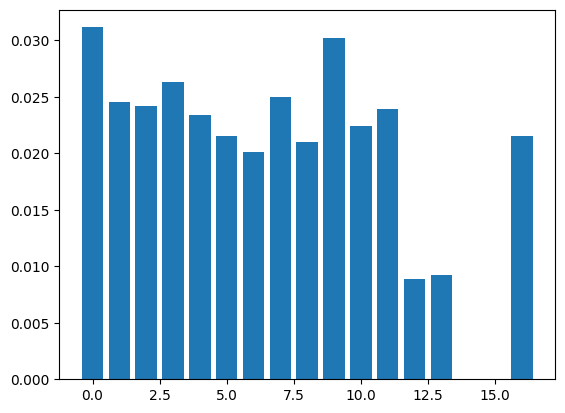

In [27]:
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### III. FINE TUNING RANDOM FOREST WITH ALL BANDS (LAST TWO CODE BLOCK - TABLE 2)

In [11]:
### FINE TUNING on all normalized features
rf_model_ft_wo_evi = RandomForestRegressor(random_state=1)

max_depth_wo_evi = list(np.linspace(1, 10, 10, dtype=int))
max_depth_wo_evi.append(None)
# Define the hyperparameters to tune

hyperparameters_wo_evi = {
    "n_estimators": np.linspace(100, 120, 5, dtype=int),
    "max_features": [None],
    # "max_depth": max_depth_wo_evi,
    # "max_leaf_nodes": np.linspace(2, 90, 89, dtype=int),
    # "min_samples_split": np.linspace(2, 25, 24, dtype=int),
    # "min_samples_leaf": np.linspace(1, 80, 80, dtype=int),
    # "bootstrap": [True, False], #Random Search always returned True
}

# Define the random search object
random_search_wo_evi = RandomizedSearchCV(
    estimator=rf_model_ft_wo_evi,
    param_distributions=hyperparameters_wo_evi,
    n_iter=55,
    cv=train_val_split,
    # cv=5,
    random_state=42,
    n_jobs=-1,
)

# Fit the random search object to the training data
random_search_wo_evi.fit(x_train_plus_val_wo_evi, y_train_plus_val)
# summarize results
print(f"""Best: {random_search_wo_evi.best_score_} using {random_search_wo_evi.best_params_}
""")

# rf_model_tuned_wo_evi = RandomForestRegressor(**random_search_wo_evi.best_params_,random_state=1).fit(x_train_wo_evi, y_train)

# print(f"""
# Training MSE: {mse(y_train, rf_model_tuned_wo_evi.predict(x_train_wo_evi))}
# Training RMSE: {np.sqrt(mse(y_train, rf_model_tuned_wo_evi.predict(x_train_wo_evi)))}
# Validation MSE: {mse(y_val, rf_model_tuned_wo_evi.predict(x_val_wo_evi))}
# Validation RMSE: {np.sqrt(mse(y_val, rf_model_tuned_wo_evi.predict(x_val_wo_evi)))}
# Test MSE: {mse(y_test, rf_model_tuned_wo_evi.predict(x_test_wo_evi))}
# Test RMSE: {np.sqrt(mse(y_test, rf_model_tuned_wo_evi.predict(x_test_wo_evi)))}
# """)


/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=55. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best: -0.021278965995474186 using {'n_estimators': 115, 'max_features': None}



In [12]:
# Run Fine Tuned RANDOM FOREST WITH ALL BANDS except EVI three times 
# to get the average test RMSE and standard deviation of the RMSE for the default random forest model
rmse_lst_3 = []
r_2_lst_3 = []

for i in range(3):
    rf_model_no_evi = RandomForestRegressor(
        **random_search_wo_evi.best_params_
        ).fit(x_train_wo_evi, y_train)
    rmse_lst_3.append(np.sqrt(mse(y_test, rf_model_no_evi.predict(x_test_wo_evi))))
    r_2_lst_3.append(rf_model_no_evi.score(x_test_wo_evi, y_test))

#calculate standard deviation of RMSE
std_3 = np.std(rmse_lst_3)
print(f"""
Test RMSEs: {rmse_lst_3}
Average Test RMSE: {np.mean(rmse_lst_3):.2f}
Standard Deviation of Test RMSE: {std_3:.2f}
Test R^2: {r_2_lst_3}
average R^2: {np.mean(r_2_lst_3):.2f}
""")


Test RMSEs: [64.59952245742001, 64.6683963478944, 64.61477637600841]
Average Test RMSE: 64.63
Standard Deviation of Test RMSE: 0.03
Test R^2: [0.01767202146003488, 0.01557625314065203, 0.01720805146233395]
average R^2: 0.02



In [3]:
### FINE TUNING on EVI bands
rf_model_ft = RandomForestRegressor(random_state=1)


max_depth = list(np.linspace(1, 10, 10, dtype=int))
max_depth.append(None)
# Define the hyperparameters to tune

hyperparameters = {
    "n_estimators": np.linspace(95, 105, 5, dtype=int),
    "max_features": [None],
    "max_depth": max_depth,
    # "max_leaf_nodes": np.linspace(2, 50, 49, dtype=int),
    # "min_samples_split": np.linspace(2, 25, 24, dtype=int),
    # "min_samples_leaf": np.linspace(1, 30, 30, dtype=int),
    # "bootstrap": [True, False],
}

# Define the random search object
random_search = RandomizedSearchCV(
    estimator=rf_model_ft,
    param_distributions=hyperparameters,
    n_iter=55,
    cv=train_val_split,
    random_state=42,
    n_jobs=-1,
)

# Fit the random search object to the training data
random_search.fit(X_train_plus_val, y_train_plus_val)
# summarize results
print(f"""Best: {random_search.best_score_} using {random_search.best_params_}
""")
# means = random_search.cv_results_['mean_test_score']
# stds = random_search.cv_results_['std_test_score']
# params = random_search.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.009300628442710623 using {'n_estimators': 100, 'max_features': None, 'max_depth': 6}



In [7]:
# Run Fined Tuned RANDOM FOREST WITH ALL BANDS except EVI three times 
# to get the average test RMSE and standard deviation of the RMSE for the default random forest model
rmse_lst_4 = []
r_2_lst_4 = []

for i in range(3):
    rf_model_evi = RandomForestRegressor(**random_search.best_params_).fit(X_train_plus_val, y_train_plus_val)
    rmse_lst_4.append(np.sqrt(mse(y_test, rf_model_evi.predict(X_test))))
    r_2_lst_4.append(rf_model_evi.score(X_test, y_test))

#calculate standard deviation of RMSE
std_4 = np.std(rmse_lst_4)
print(f"""
Test RMSEs: {rmse_lst_4}
Average Test RMSE: {np.mean(rmse_lst_4):.2f}
Standard Deviation of Test RMSE: {std_4:.2f}
Test R^2: {r_2_lst_4}
average R^2: {np.mean(r_2_lst_4):.2f}
""")


Test RMSEs: [64.6609304432906, 64.69087185319182, 64.68228225828993]
Average Test RMSE: 64.68
Standard Deviation of Test RMSE: 0.01
Test R^2: [0.015803541582792846, 0.014891861158387254, 0.015153447309192436]
average R^2: 0.02



### IV. SPECTURAL BANDS

In [7]:
# tuned_parameters_rf = {'n_estimators': 100, 'max_features': None, 'max_depth': 20}

# # define a function to try different bands
# def try_bands(x_train: np.ndarray, x_val: np.ndarray, x_test: np.ndarray):
#     rf = RandomForestRegressor(
#         # **tuned_parameters_rf,
#         random_state=1).fit(x_train, y_train)
#     print(f"""
#     Training MSE: {mse(y_train, rf.predict(x_train))}
#     Training RMSE: {np.sqrt(mse(y_train, rf.predict(x_train)))}
#     Validation MSE: {mse(y_val, rf.predict(x_val))}
#     Validation RMSE: {np.sqrt(mse(y_val, rf.predict(x_val)))}
#     Test MSE: {mse(y_test, rf.predict(x_test))}
#     Test RMSE: {np.sqrt(mse(y_test, rf.predict(x_test)))}
#     """)

In [3]:
# tuned_parameters_rf = {'n_estimators': 100, 'max_features': None, 'max_depth': 6}


# define a function to try different bands
def try_bands(x_train: np.ndarray, x_test: np.ndarray):
    
    rmse_lst = []
    r_2_lst = []

    for i in range(3):
        rf = RandomForestRegressor(
        # **tuned_parameters_rf,
        # random_state=1
        ).fit(x_train, y_train)
        rmse_lst.append(np.sqrt(mse(y_test, rf.predict(x_test))))
        r_2_lst.append(rf.score(x_test, y_test))
    
    #calculate standard deviation of RMSE
    std = np.std(rmse_lst)
    print(f"""
    Test RMSEs: {rmse_lst}
    Average Test RMSE: {np.mean(rmse_lst):.4f}
    Standard Deviation of Test RMSE: {std:.4f}
    Test R^2: {r_2_lst}
    average R^2: {np.mean(r_2_lst):.4f}
    """)

In [16]:
X_train[0].reshape(17,-1)

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.],
       [  1.,  18., 206.]])

In [17]:
x_train_wo_evi[0].reshape(16,-1)

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.]])

In [8]:
x_train_wo_evi[0,3:12].reshape(3,-1)

array([[ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.]])

In [28]:
# 1. RBG
# try_bands(x_train_wo_evi[:,17:64], x_val_wo_evi[:,17:64], x_test_wo_evi[:,17:64]) #16 bands slicing
try_bands(x_train_wo_evi[:,3:12], x_test_wo_evi[:,3:12])


    Test RMSEs: [65.11888939482841, 65.12743765582994, 65.02092166138847]
    Average Test RMSE: 65.0891
    Standard Deviation of Test RMSE: 0.0483
    Test R^2: [0.0018130936998598246, 0.001551009308146556, 0.004814267392725724]
    average R^2: 0.0027
    


In [4]:
x_train_wo_evi[0,3:].reshape(15,-1)

array([[ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.]])

In [34]:
# 2. No Coastal Aerosol
# try_bands(x_train_wo_evi[:,17:], x_val_wo_evi[:,17:], x_test_wo_evi[:,17:])
try_bands(x_train_wo_evi[:,3:], x_test_wo_evi[:,3:])


    Test RMSEs: [64.69186415537499, 64.64233994300072, 64.6347686988806]
    Average Test RMSE: 64.6563
    Standard Deviation of Test RMSE: 0.0253
    Test R^2: [0.014861639508067515, 0.016369387889071052, 0.01659979017219848]
    average R^2: 0.0159
    


In [10]:
# x_train_wo_evi[:, np.r_[0:16, 32:256]].shape #no Blue
x_train_wo_evi[0, np.r_[0:3, 6:48]].reshape(15,-1) #no Blue

array([[195.,  24.,   6.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.]])

In [42]:
# 3. No Blue
# try_bands(x_train_wo_evi[:, np.r_[0:16, 32:256]], x_val_wo_evi[:, np.r_[0:16, 32:256]], x_test_wo_evi[:, np.r_[0:16, 32:256]])
try_bands(x_train_wo_evi[:, np.r_[0:3, 6:48]], x_test_wo_evi[:, np.r_[0:3, 6:48]])


    Test RMSEs: [64.57716755616819, 64.88128037450643, 64.84696601949653]
    Average Test RMSE: 64.7685
    Standard Deviation of Test RMSE: 0.1360
    Test R^2: [0.018351780209931445, 0.009084271120567089, 0.01013214324231626]
    average R^2: 0.0125
    


In [11]:
x_train_wo_evi[0, np.r_[0:6, 9:48]].reshape(15,-1) # no green

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.]])

In [44]:
# 4. No Green
# try_bands(x_train_wo_evi[:, np.r_[0:32, 48:256]], x_val_wo_evi[:, np.r_[0:32, 48:256]], x_test_wo_evi[:, np.r_[0:32, 48:256]])
try_bands(x_train_wo_evi[:, np.r_[0:6, 9:48]], x_test_wo_evi[:, np.r_[0:6, 9:48]])


    Test RMSEs: [64.6288049185282, 64.57651101282175, 64.59751330946375]
    Average Test RMSE: 64.6009
    Standard Deviation of Test RMSE: 0.0215
    Test R^2: [0.01678125635206995, 0.01837174055676638, 0.017733124436765224]
    average R^2: 0.0176
    


In [5]:
x_train_wo_evi[0, np.r_[0:9, 12:48]].reshape(15,-1) # no red

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.]])

In [46]:
# 5. No Red
try_bands(x_train_wo_evi[:, np.r_[0:9, 12:48]], x_test_wo_evi[:, np.r_[0:9, 12:48]])


    Test RMSEs: [64.74579890960757, 64.7304926886739, 64.79559368199992]
    Average Test RMSE: 64.7573
    Standard Deviation of Test RMSE: 0.0278
    Test R^2: [0.013218300114597237, 0.013684804927222016, 0.011699886071398269]
    average R^2: 0.0129
    


In [6]:
x_train_wo_evi[0, np.r_[0:12, 15:48]].reshape(15,-1) # no Vegetation_Red_Edge

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.]])

In [48]:
# 6. No Vegetation_Red_Edge
# try_bands(x_train_wo_evi[:, np.r_[0:64, 80:256]], x_val_wo_evi[:, np.r_[0:64, 80:256]], x_test_wo_evi[:, np.r_[0:64, 80:256]])
try_bands(x_train_wo_evi[:, np.r_[0:12, 15:48]], x_test_wo_evi[:, np.r_[0:12, 15:48]])


    Test RMSEs: [64.67806023077343, 64.71082604074472, 64.72664813324909]
    Average Test RMSE: 64.7052
    Standard Deviation of Test RMSE: 0.0202
    Test R^2: [0.015282011527861794, 0.0142840454450186, 0.0138019624110709]
    average R^2: 0.0145
    


In [7]:
x_train_wo_evi[0, np.r_[0:15, 18:48]].reshape(15,-1) # no Vegetation_Red_Edge 2

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.]])

In [50]:
# 7. No Vegetation_Red_Edge 2
# try_bands(x_train_wo_evi[:, np.r_[0:80, 96:256]], x_val_wo_evi[:, np.r_[0:80, 96:256]], x_test_wo_evi[:, np.r_[0:80, 96:256]])
try_bands(x_train_wo_evi[:, np.r_[0:15, 18:48]], x_test_wo_evi[:, np.r_[0:15, 18:48]])


    Test RMSEs: [64.61041343481216, 64.70874628857426, 64.52666641803116]
    Average Test RMSE: 64.6153
    Standard Deviation of Test RMSE: 0.0744
    Test R^2: [0.01734076781474725, 0.014347404610029924, 0.019886532196272788]
    average R^2: 0.0172
    


In [8]:
x_train_wo_evi[0, np.r_[0:18, 21:48]].reshape(15,-1) # no Vegetation_Red_Edge 3

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.]])

In [52]:
# 8. Vegetation_Red_Edge 3
try_bands(x_train_wo_evi[:, np.r_[0:18, 21:48]], x_test_wo_evi[:, np.r_[0:18, 21:48]])


    Test RMSEs: [64.60185279657341, 64.51747288917818, 64.57749016019744]
    Average Test RMSE: 64.5656
    Standard Deviation of Test RMSE: 0.0355
    Test R^2: [0.017601147913237747, 0.02016579842957844, 0.0183419722708712]
    average R^2: 0.0187
    


In [9]:
x_train_wo_evi[0, np.r_[0:21, 24:48]].reshape(15,-1) # no NIR

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.]])

In [10]:
# 9. No NIR
try_bands(x_train_wo_evi[:, np.r_[0:21, 24:48]], x_test_wo_evi[:, np.r_[0:21, 24:48]])


    Test RMSEs: [64.82739056589071, 64.86840230185466, 64.72165194578287]
    Average Test RMSE: 64.8058
    Standard Deviation of Test RMSE: 0.0618
    Test R^2: [0.010729678911160057, 0.009477599310815488, 0.013954203883559724]
    average R^2: 0.0114
    


In [11]:
x_train_wo_evi[0, np.r_[0:24, 27:48]].reshape(15,-1) # no narrow NIR

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.]])

In [13]:
# 10. No Narrow NIR
try_bands(x_train_wo_evi[:, np.r_[0:24, 27:48]], x_test_wo_evi[:, np.r_[0:24, 27:48]])


    Test RMSEs: [64.40074785193637, 64.72567789546203, 64.48478967498731]
    Average Test RMSE: 64.5371
    Standard Deviation of Test RMSE: 0.1377
    Test R^2: [0.023708024073481715, 0.013831527959657697, 0.021158274367252594]
    average R^2: 0.0196
    


In [12]:
x_train_wo_evi[0, np.r_[0:27, 30:48]].reshape(15,-1) # no water vapor

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.]])

In [14]:
# 11. No water vapor
try_bands(x_train_wo_evi[:, np.r_[0:27, 30:48]], x_test_wo_evi[:, np.r_[0:27, 30:48]])


    Test RMSEs: [64.55565650881898, 64.49948677154148, 64.61952916499101]
    Average Test RMSE: 64.5582
    Standard Deviation of Test RMSE: 0.0490
    Test R^2: [0.01900565727373804, 0.020712036709099158, 0.01706346612762366]
    average R^2: 0.0189
    


In [15]:
x_train_wo_evi[0, np.r_[0:30, 33:48]].reshape(15,-1) # no SWIR1

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.]])

In [16]:
# 12. no SWIR1
try_bands(x_train_wo_evi[:, np.r_[0:30, 33:48]], x_test_wo_evi[:, np.r_[0:30, 33:48]])


    Test RMSEs: [64.72974042566605, 64.49449193328205, 64.5942584938026]
    Average Test RMSE: 64.6062
    Standard Deviation of Test RMSE: 0.0964
    Test R^2: [0.013707729644558131, 0.020863702895499214, 0.017832107103484596]
    average R^2: 0.0175
    


In [17]:
x_train_wo_evi[0, np.r_[0:33, 36:48]].reshape(15,-1) # no SWIR2

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.]])

In [18]:
# 13. no SWIR2
try_bands(x_train_wo_evi[:, np.r_[0:33, 36:48]], x_test_wo_evi[:, np.r_[0:33, 36:48]])


    Test RMSEs: [64.57172008519541, 64.5321485844517, 64.68434294644806]
    Average Test RMSE: 64.5961
    Standard Deviation of Test RMSE: 0.0645
    Test R^2: [0.018517389041607046, 0.019719984823218795, 0.01509069460827428]
    average R^2: 0.0178
    


### IV. Environmental factors


In [19]:
x_train_wo_evi[0, np.r_[0:36, 39:48]].reshape(15,-1) # no cloud

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.],
       [ 75.,  75.,  75.]])

In [20]:
# 1. no Cloud
try_bands(x_train_wo_evi[:, np.r_[0:36, 39:48]], x_test_wo_evi[:, np.r_[0:36, 39:48]])


    Test RMSEs: [64.74596678266727, 64.62551993711998, 64.59454056669918]
    Average Test RMSE: 64.6553
    Standard Deviation of Test RMSE: 0.0653
    Test R^2: [0.013213183048138788, 0.016881204764017887, 0.01782352914148433]
    average R^2: 0.0160
    


In [21]:
x_train_wo_evi[0, np.r_[0:42, 45:48]].reshape(15,-1) # no latitude

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.]])

In [22]:
# 2. no Latitude
try_bands(x_train_wo_evi[:, np.r_[0:42, 45:48]],  x_test_wo_evi[:, np.r_[0:42, 45:48]])


    Test RMSEs: [64.5625280600838, 64.76977262303475, 64.62389845128197]
    Average Test RMSE: 64.6521
    Standard Deviation of Test RMSE: 0.0869
    Test R^2: [0.018796804570581194, 0.012487404771741262, 0.01693053800594979]
    average R^2: 0.0161
    


In [23]:
x_train_wo_evi[0, :45].reshape(15,-1) # no Longitude

array([[195.,  24.,   6.],
       [ 83., 120.,  22.],
       [ 24.,  98., 103.],
       [169.,  38.,  18.],
       [ 28.,  99.,  98.],
       [ 17.,  48., 160.],
       [ 16.,  42., 167.],
       [ 19.,  71., 135.],
       [ 17.,  34., 174.],
       [ 60.,  85.,  80.],
       [ 17., 173.,  35.],
       [157.,  45.,  23.],
       [221.,   0.,   4.],
       [  0., 225.,   0.],
       [ 75.,  75.,  75.]])

In [24]:
# 3. no Longitude
try_bands(x_train_wo_evi[:, :45], x_test_wo_evi[:, :45])


    Test RMSEs: [64.739677091599, 64.64851610957834, 64.50674608525955]
    Average Test RMSE: 64.6316
    Standard Deviation of Test RMSE: 0.0958
    Test R^2: [0.013404894843347948, 0.01618141954715535, 0.02049158972718823]
    average R^2: 0.0167
    
